</div>
<div align="center">
  <img src="img/evolnode.png" width="800" alt="Fourier reconstruction convergence">
  <p><em> Evolution Node free you from coding and debugging, let LLM evolve your code for you.</em></p>
</div>
<div align="left">
<p><em>Bored of manual coding, a function? EvolNode let LLM automate function design and guide the evolution of it with genetic algorithm. A node here takes a task, input, and output, it uses either code or another LLM to complete the task, ensuring aligned input and output value types and ,.names.Fitness evaluation is done by running the function with a few specified test cases, the more diverse the test case, the better the evolution.
</em></p>
</div>

In [3]:
from methods.meta_prompt import MetaPrompt, PromptMode
from methods.eoh_evolution import EvolNode


# Code + Compilor Task
# mp = MetaPrompt("Generate Fibonacci sequence.", "fibonacci", ["n"], ["sequence"], ["int"], ["list"], PromptMode.CODE) # 
# node = EvolNode(mp, None, None)
# input_dict = {"n": 10}
# reasoning, code = node.evolve([input_dict], "i1", replace=True) # Evolution with guaranteed structural fitness
# node(input_dict) # Ok we need a output dictionary here as well ...


# Prompt + LLM Task
mp = MetaPrompt("Get the age of a celebrity.", "get_celeb_age", ["name"], ["age"], ["str"], ["int"], PromptMode.PROMPT) # 
node = EvolNode(mp, None, None)
input_dict = {"name": "Dilireba"}
reasoning, code = node.evolve([input_dict], "i1", replace=True)
node(input_dict)

KeyboardInterrupt: 


</div>
<div align="center">
  <img src="https://github.com/user-attachments/assets/af98faeb-66d6-4278-af86-67d668d1954e" width="1000" alt="Fourier reconstruction convergence">
  <p><em> But how do we know what are the tasks suitable for our goal? Design of tasks topology is the fundation of planning, let's ask LLM for help on this, too! Evolution Graph autuomate planning by imagning topology of tasks which works best for your goal.</em></p>
</div>


In [ ]:
from methods.meta_prompt import MetaPlan, extract_json_from_text

mp = MetaPlan("Help me date Dilireba, I'm a white colar worker living on salary.")
prompt = mp._get_prompt_i1()
print("MetaPrompt I1: ")
print(prompt)

from methods.llm import get_openai_response
response = get_openai_response(prompt)


MetaPrompt I1: 
Goal: Help me date Dilireba, I'm a white colar worker living on salary.
First, describe the intuition for your tactics and main steps in one sentence. The description must be inside a brace.
Generate a JSON-style plan represented as a Directed Acyclic Graph (DAG) to achieve the goal. Use creative topology in the DAG, include parallel tasks if required.

The plan should include:

- **Nodes**: Each node represents a key action or step and must contain the following attributes:
  - `task`: Description of the task.
  - `name`: Concise name used for the task function.
  - `input`: The resources, information, or prerequisites needed to perform the action.
  - `output`: The immediate result or outcome of the action.
  - `target`: The purpose or goal that the action contributes to.
  - `mode`: The execution mode for this task ("CODE" or "PROMPT").

- **Edges**: Each edge represents a dependency or relationship between nodes, indicating that one step supports or leads to another

In [ ]:
import re 
# from methods.meta_prompt import parse_json_from_response

tactic = re.findall(r"\{(.*)\}", response, re.DOTALL)
plan_dict = extract_json_from_text(response)

In [ ]:
from methods.meta_prompt import MetaPrompt, MetaPlan, extract_json_from_text
from methods.eoh_evolution import EvolNode
from methods.llm import get_openai_response as get_response
from typing import Optional, List, Dict

# Collect MetaPrompt from parsed Plan-Graph Response
meta_node_prompts = []
for node in plan_dict["nodes"]:
    node_prompt = MetaPrompt(task=node.get("task"),  func_name=node.get("name"), input=node.get("input"), output=node.get("output"), mode=node.get("mode").lower())
    meta_node_prompts.append(node_prompt)
    
edges = plan_dict["edges"]

EvolNode(meta_prompt = node_prompt)


#### RepoRAG
* Smooth Dependency Animation

In [1]:
from tools.repo import *

# (I). Pick top growing repo
# fastest_repos = get_fastest_growing_repos(days_ago=14, top_n = 50, print=False)
# repo_url = fastest_repos[0]['html_url']

# (I). Build a GIF of file-dependency of a git repo
repo_url = "https://github.com/xjdr-alt/entropix.git"
temp_repo = "entropix_repo"

file_graph = create_gif_from_repo(repo_url, temp_repo, frame_count=60, fps = 10, output_name="entropix_repo_evolution")

# (II). Build function-level dependency graph of a module within the repo


Repo already cloned, skipping cloning...


success: successfully compiled d2_output/evolve_graph_0.d2 to d2_output/evolve_graph_0.png in 623.281708ms
success: successfully compiled d2_output/evolve_graph_1.d2 to d2_output/evolve_graph_1.png in 574.416751ms
success: successfully compiled d2_output/evolve_graph_2.d2 to d2_output/evolve_graph_2.png in 582.627458ms
success: successfully compiled d2_output/evolve_graph_3.d2 to d2_output/evolve_graph_3.png in 551.716375ms
success: successfully compiled d2_output/evolve_graph_4.d2 to d2_output/evolve_graph_4.png in 564.121084ms
success: successfully compiled d2_output/evolve_graph_5.d2 to d2_output/evolve_graph_5.png in 549.071917ms
success: successfully compiled d2_output/evolve_graph_6.d2 to d2_output/evolve_graph_6.png in 539.922374ms
success: successfully compiled d2_output/evolve_graph_7.d2 to d2_output/evolve_graph_7.png in 559.876168ms
success: successfully compiled d2_output/evolve_graph_8.d2 to d2_output/evolve_graph_8.png in 554.661875ms
success: successfully compiled d2_out

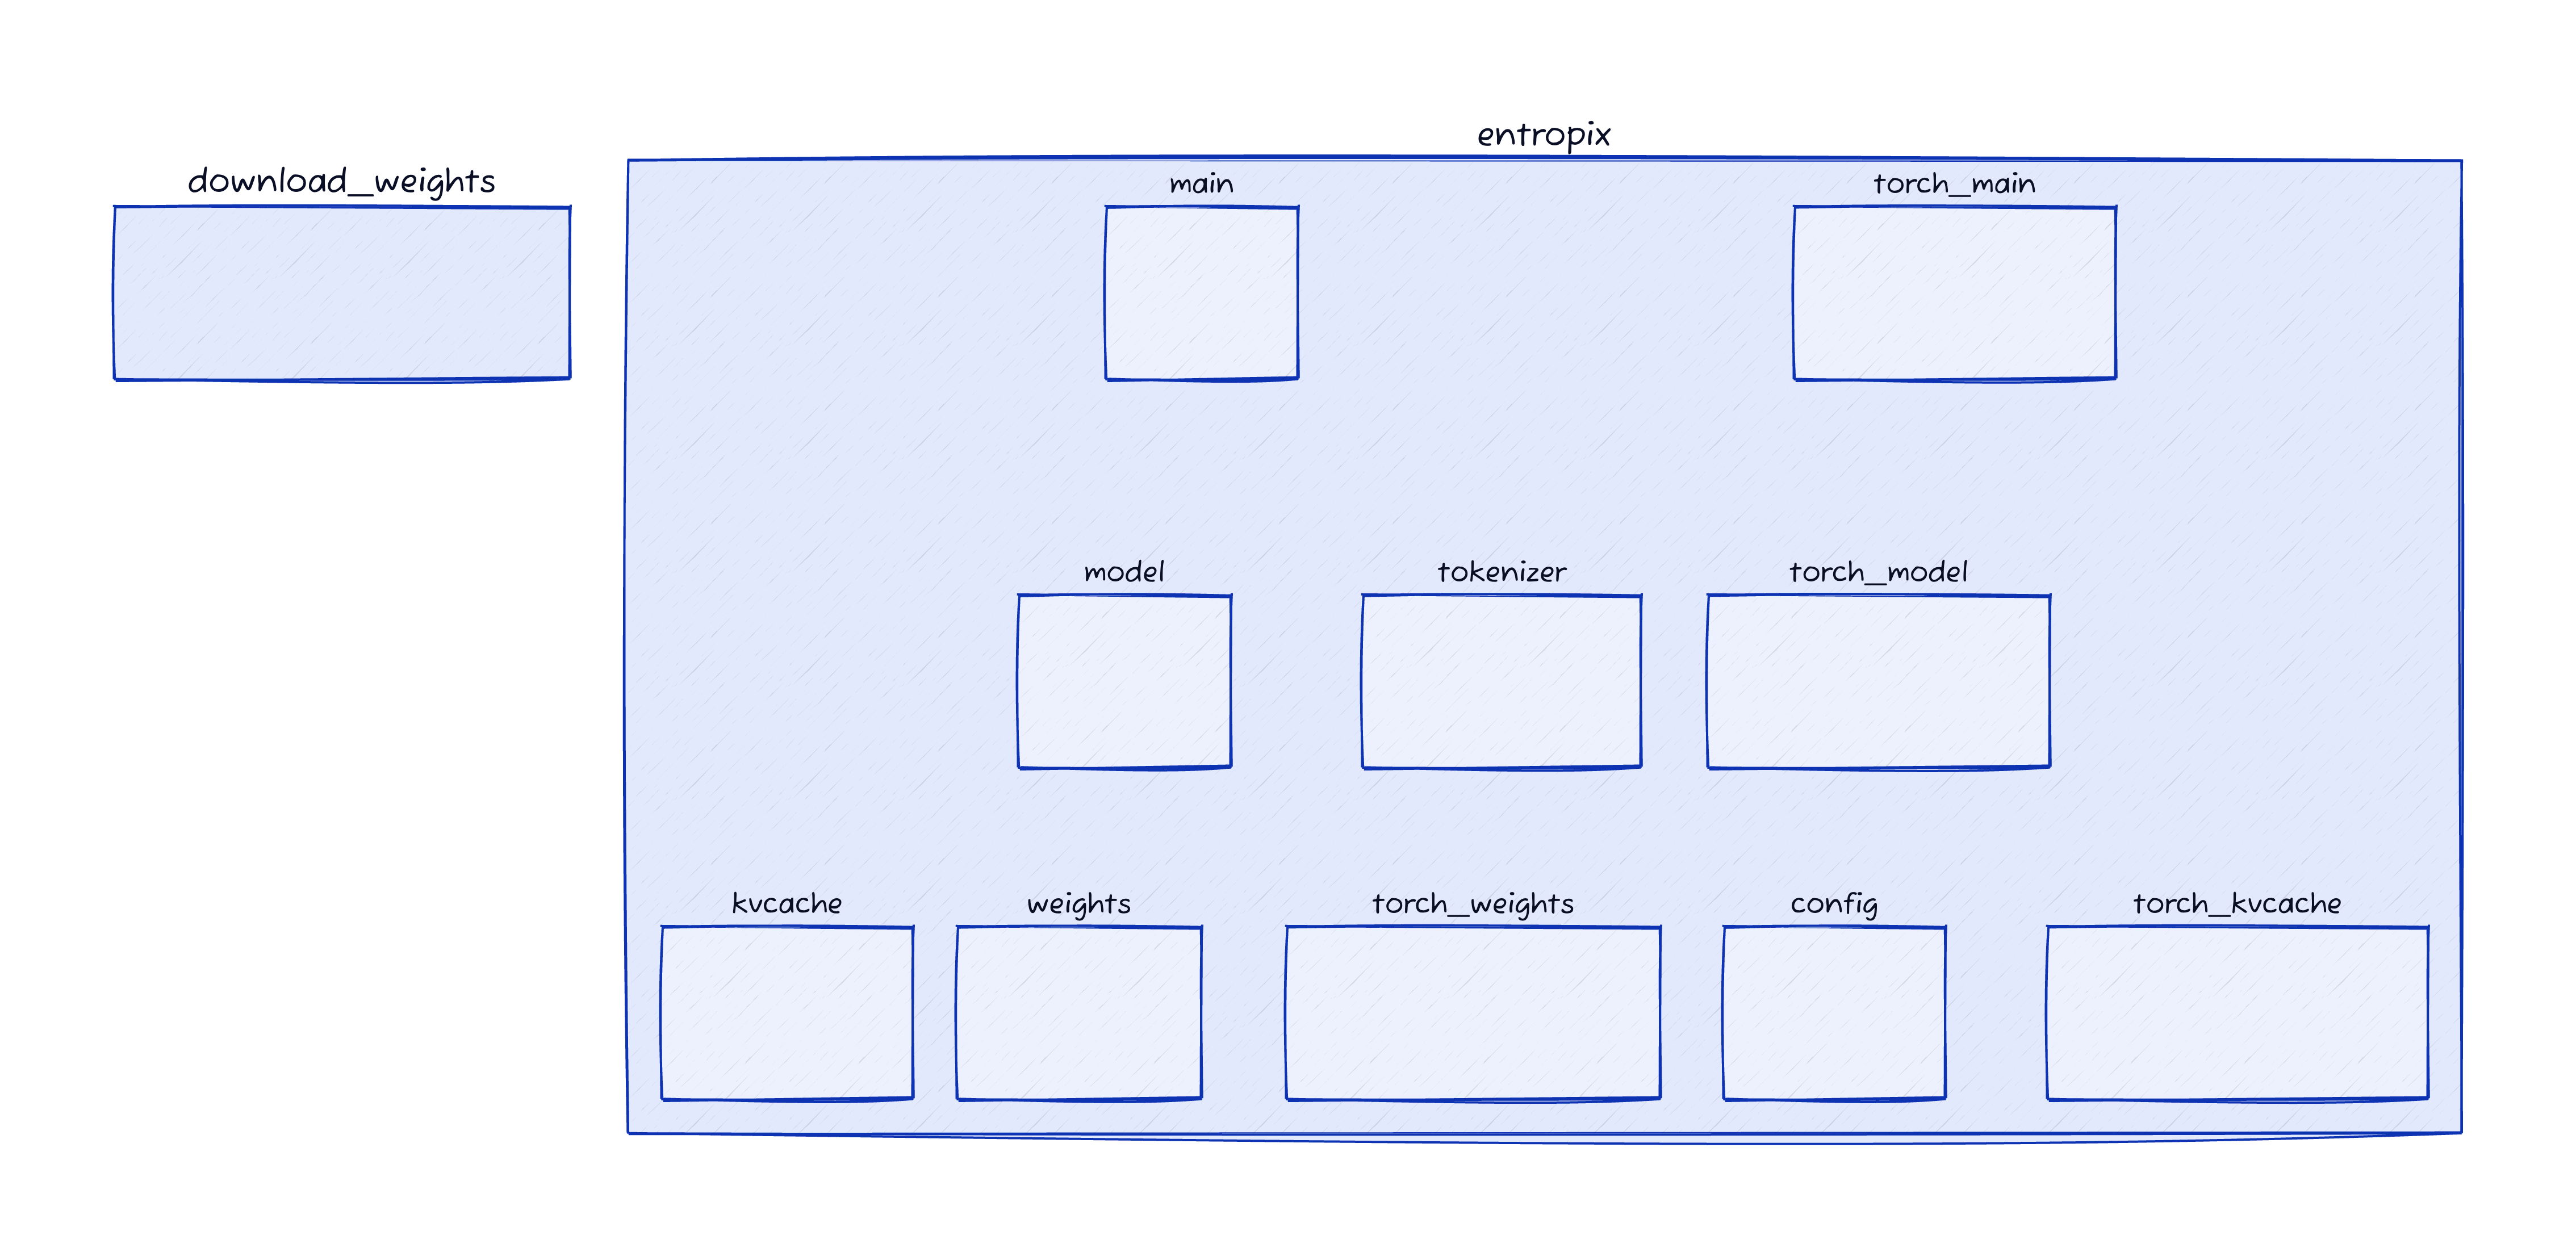

In [4]:
file_graph

In [3]:
# (II). Build function-level dependency graph of a module within the repo
from tools.repo import *

temp_repo = "hdcnn" # Contains an interesting new DL model architecture's implementation

python_files = get_python_files(temp_repo) # get all python files 

start_file = python_files[0] # pick the first one for debugging purpose 

dag = build_cross_file_dag(temp_repo, start_file)

name_map = {dag[k]["name"]: k for k in dag} # Map name to node-id for all nodes in the DAG

pick_object = list(name_map.keys())[0] # pick the first object from 'start_file'

sub_dag = extract_subgraph_dag(dag, name_map[pick_object], depth=6) # Extact depedency graph starting from pick_object

sub_dag = decide_opacity_of_dag(sub_dag, progress=1.0, cap_node_number=20) # limit number of nodes for easy understanding

func_graph = create_evolution_gif(sub_dag, frame_count=60, fps=10) # Sick Animation once again ...

  Number of objects in the subgraph: 15


success: successfully compiled d2_output/evolve_graph_0.d2 to d2_output/evolve_graph_0.png in 319.507084ms
success: successfully compiled d2_output/evolve_graph_1.d2 to d2_output/evolve_graph_1.png in 315.500917ms
success: successfully compiled d2_output/evolve_graph_2.d2 to d2_output/evolve_graph_2.png in 308.329042ms
success: successfully compiled d2_output/evolve_graph_3.d2 to d2_output/evolve_graph_3.png in 315.55475ms
success: successfully compiled d2_output/evolve_graph_4.d2 to d2_output/evolve_graph_4.png in 341.232833ms
success: successfully compiled d2_output/evolve_graph_5.d2 to d2_output/evolve_graph_5.png in 338.376958ms
success: successfully compiled d2_output/evolve_graph_6.d2 to d2_output/evolve_graph_6.png in 336.919542ms
success: successfully compiled d2_output/evolve_graph_7.d2 to d2_output/evolve_graph_7.png in 338.451333ms
success: successfully compiled d2_output/evolve_graph_8.d2 to d2_output/evolve_graph_8.png in 348.783125ms
success: successfully compiled d2_outp

In [14]:
# BreakDown on Task (When something is hard, we break it down)

# 1. Construct step-wise PNG
#    - transparency changing function
#    - growing strategy (code-based subnodes as importance score)
# 2. Animate into GIF (not perfect due to scale disconnection)


# 3. Agent to understand codebase with repo-DAG
